In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$sin(x)=y$

$x$ wird gesucht.

In [3]:
x = np.random.random(size = (100, ))

In [4]:
y = np.sin(x)

Verlustfunktion: quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2$

In [5]:
from sklearn.metrics import mean_squared_error

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-\frac{2}{n}(y_i-\hat{y}_i)$

In [6]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [7]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

0.06540926448542572

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [8]:
iterations = 100
particles = 100
randomization = True

In [9]:
h_0 = 2
epsilon = 0.5

In [10]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [11]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.sin(param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [12]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [13]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.sin(param_mean)))

In [14]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.sin(param_dict["particle_{}".format(i+1)]))]

### EnKF

In [15]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.sin(param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, np.sin(param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.sin(param_dict["particle_{}".format(i+1)])))

Mit Randomization: Loss schwankt ungleichmäßig.

Ohne Randomization: Loss bleibt gleich ?!

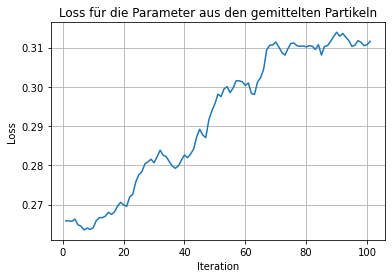

In [16]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

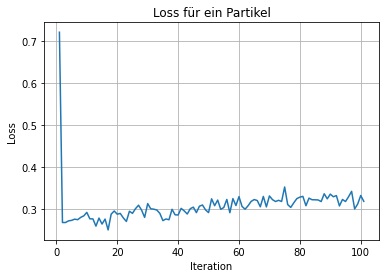

In [17]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

## EnKF wie für inverse Probleme

Noise führt bei zu großer Zahl an Iterationen (z.B. 200) zu Error: ``SVD did not converge``. 

Für eine geringe Zahl an Epochen (z.B. 100) gibt es keinen Error, aber dann gibt es auch keine Verminderung beim Loss.

In [18]:
noise = False
y = np.sin(x)
stddev_noise = np.ones(shape = y.shape) * 0.1
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [19]:
particles = 1000
epochs = 300    

In [20]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [21]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.sin(param_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [22]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [23]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.sin(param_mean)))

In [24]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.sin(param_dict["particle_{}".format(i+1)]))]

In [25]:
for epoch in range(epochs):

    # update the predictions and the loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.sin(param_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

    # compute the matrices C
    param_diff_dict = {}
    pred_diff_param_dict = {}
    pred_diff_w_dict = {}
    c_param_w_dict = {}
    c_w_w_dict = {}

    for i in range(particles):
        param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
        pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
    for i in range(particles):
        param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
        pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
        pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
        c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
        c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
    c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
    c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

    # write the updates back into the dictionary
    for i in range(particles):
        if noise:
            param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma)), y - y_pred_dict["particle_{}".format(str(i+1))])
        else:
            param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y - y_pred_dict["particle_{}".format(str(i+1))])

    # compute loss for the parameter means
    param_mean = np.mean(list(param_dict.values()), axis = 0)
    loss_evolution.append(mean_squared_error(y, np.sin(param_mean)))

    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.sin(param_dict["particle_{}".format(i+1)])))

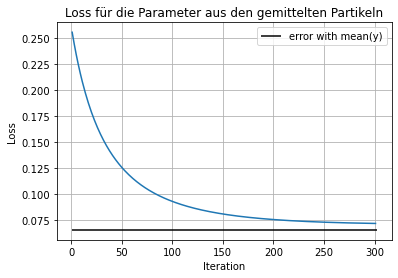

In [26]:
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 1, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

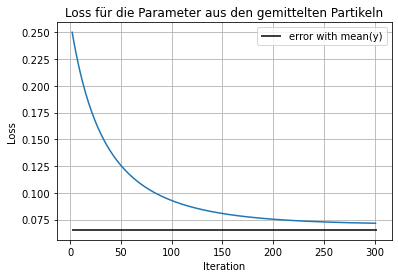

In [27]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

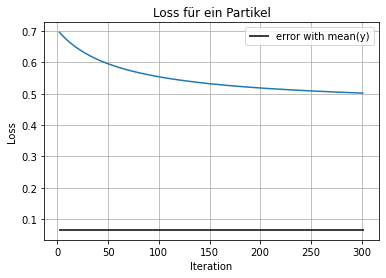

In [28]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))[1:]+1, loss_evolution_single_dict["particle_1"][1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

In [29]:
np.sin(param_mean)

array([ 0.36560507,  0.22254124,  0.49660792,  0.49126135,  0.49056447,
        0.39322113,  0.28045052,  0.3502087 ,  0.42473068,  0.27151173,
        0.54834343,  0.30134105,  0.30092245,  0.3265481 ,  0.3552719 ,
        0.38706008,  0.30407755,  0.42703229,  0.52120697,  0.36017797,
        0.38974501,  0.43707565,  0.45073444,  0.4839169 ,  0.47685737,
        0.54900278,  0.43610933,  0.4099505 ,  0.38512886,  0.40874325,
        0.45925963, -0.11676737,  0.39376408,  0.47150867,  0.37890277,
        0.44462185,  0.37649751,  0.36784168,  0.28045559,  0.3204725 ,
        0.43045254,  0.4629194 ,  0.44144653,  0.41181291,  0.45431205,
        0.4447568 ,  0.40656438,  0.2496658 ,  0.45603657,  0.29442054,
        0.4034393 ,  0.40646399,  0.53933445,  0.41243373,  0.24711043,
        0.28111301,  0.26137507,  0.59793238,  0.39138941,  0.31330666,
        0.42218525,  0.22026437,  0.43657853,  0.44863409,  0.37526997,
        0.45653786,  0.50831972,  0.25501058,  0.36433505,  0.39

In [30]:
y

array([0.36584457, 0.8138308 , 0.66835414, 0.56353476, 0.15538645,
       0.15536262, 0.05805096, 0.76185763, 0.56556238, 0.65037088,
       0.02058304, 0.82483475, 0.73957765, 0.21074705, 0.18082476,
       0.18237803, 0.2995703 , 0.50100222, 0.41863797, 0.28712982,
       0.5743852 , 0.13904191, 0.28800666, 0.35822109, 0.44042319,
       0.70694964, 0.19834961, 0.49186844, 0.55836576, 0.04643371,
       0.57085338, 0.16969889, 0.06500572, 0.81276674, 0.82240864,
       0.72318122, 0.29992475, 0.09751689, 0.63207887, 0.42607743,
       0.12173553, 0.47518732, 0.03438174, 0.78908646, 0.25590135,
       0.61510748, 0.3066877 , 0.49693917, 0.51987984, 0.18380347,
       0.82465083, 0.69981096, 0.80726248, 0.78010107, 0.56290801,
       0.79673567, 0.08837705, 0.19473068, 0.04521187, 0.31962181,
       0.3789647 , 0.26803135, 0.73707876, 0.34923383, 0.27725364,
       0.51644657, 0.14045824, 0.71888501, 0.07448161, 0.83431382,
       0.69774503, 0.19741045, 0.00552209, 0.728042  , 0.64944

In [31]:
print("Error mit Mittelwert als prediction: {}".format(mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))))
print("Final model error: {}".format(loss_evolution[-1]))

Error mit Mittelwert als prediction: 0.06540926448542572
Final model error: 0.07164440235578616
